In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Term 8/Term 8 Artificial Intelligence/folder

/content/drive/MyDrive/Term 8/Term 8 Artificial Intelligence/folder


In [4]:
!git clone https://github.com/Bjarten/early-stopping-pytorch.git ./earlystopping

fatal: destination path './earlystopping' already exists and is not an empty directory.


In [91]:
import os
import torch
import datetime
from model import *
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage import io
from scipy.io import loadmat, savemat
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from earlystopping.pytorchtools import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler

TODO:

- Data augmentation
- Test out different loss function (can learn from 0-1 output instead of sigmoid?)
- Train different models in encoder-decoder format
- Find a way to calculate the training accuracy?
- Hyperparameter tuning
- Save and load model
- Classify the nucleus based on multiclass?

# ignore

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


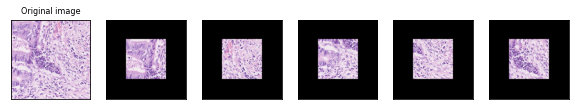

<Figure size 7200x7200 with 0 Axes>

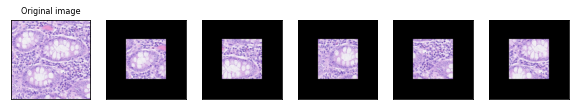

<Figure size 7200x7200 with 0 Axes>

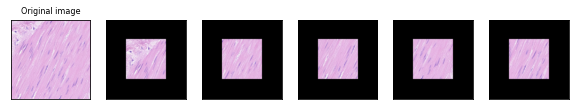

<Figure size 7200x7200 with 0 Axes>

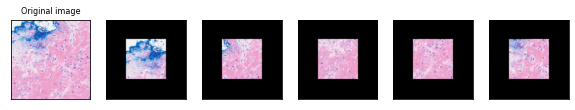

<Figure size 7200x7200 with 0 Axes>

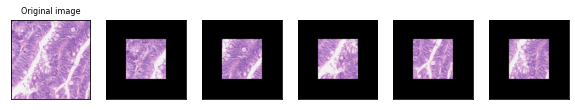

<Figure size 7200x7200 with 0 Axes>

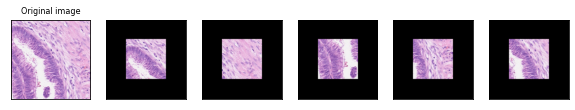

<Figure size 7200x7200 with 0 Axes>

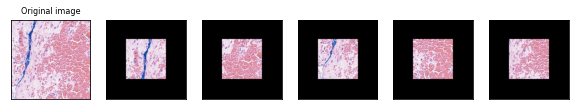

<Figure size 7200x7200 with 0 Axes>

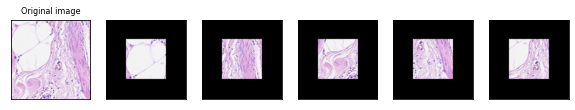

<Figure size 7200x7200 with 0 Axes>

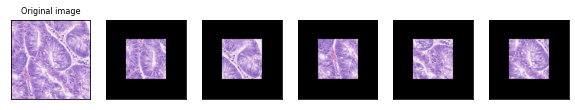

<Figure size 7200x7200 with 0 Axes>

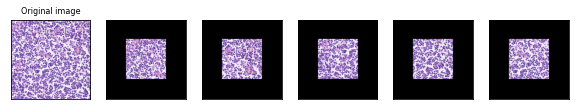

<Figure size 7200x7200 with 0 Axes>

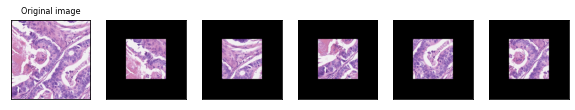

<Figure size 7200x7200 with 0 Axes>

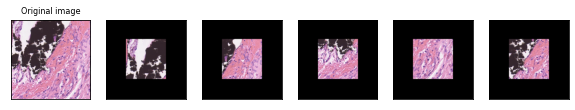

<Figure size 7200x7200 with 0 Axes>

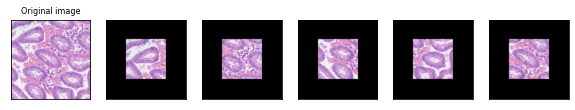

<Figure size 7200x7200 with 0 Axes>

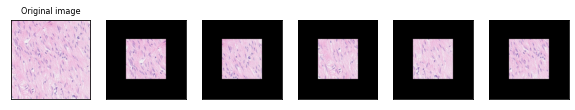

<Figure size 7200x7200 with 0 Axes>

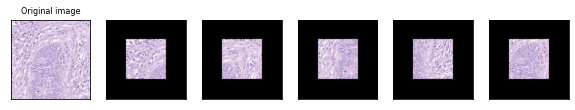

<Figure size 7200x7200 with 0 Axes>

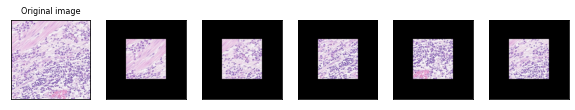

<Figure size 7200x7200 with 0 Axes>

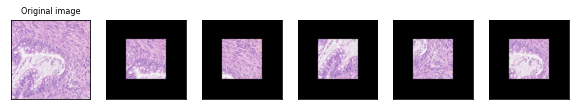

<Figure size 7200x7200 with 0 Axes>

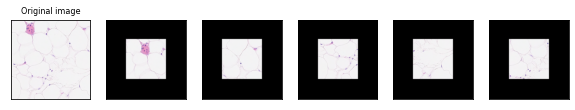

<Figure size 7200x7200 with 0 Axes>

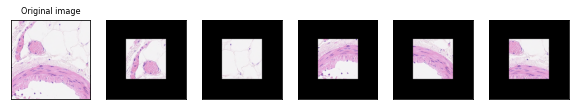

<Figure size 7200x7200 with 0 Axes>

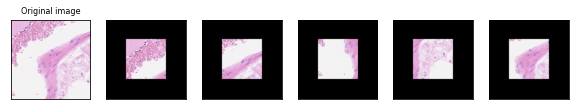

<Figure size 7200x7200 with 0 Axes>

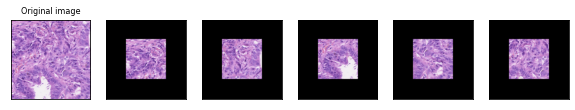

<Figure size 7200x7200 with 0 Axes>

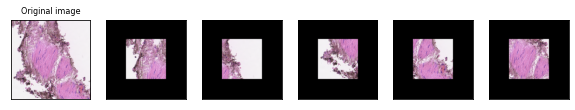

<Figure size 7200x7200 with 0 Axes>

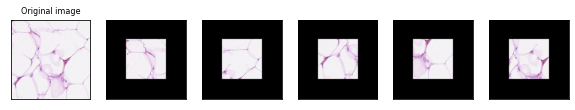

<Figure size 7200x7200 with 0 Axes>

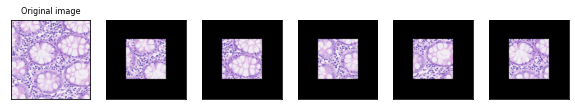

<Figure size 7200x7200 with 0 Axes>

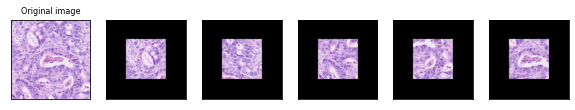

<Figure size 7200x7200 with 0 Axes>

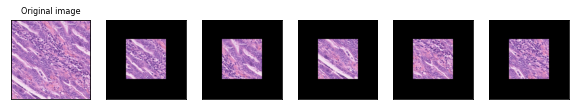

<Figure size 7200x7200 with 0 Axes>

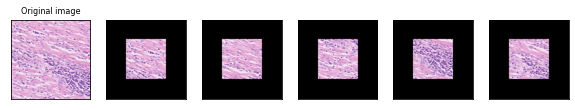

<Figure size 7200x7200 with 0 Axes>

In [ ]:
%pylab inline
import torchvision.transforms as T
from torch.nn import ConstantPad2d
import numpy as np

def plot(imgs, orig_img, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(10, 10))
    fig = plt.figure(figsize=(100, 100))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def five_crop():
    root_dir = "./Train"
    fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
    img_path = "./cropped_train/Images/"
    label_path = "./cropped_train/Labels/"
    for idx in range(len(fileNames)):
        size = 500
        img_name = os.path.join(root_dir,"Images", fileNames[idx])+".png"
        mask_name = os.path.join(root_dir,"Labels", fileNames[idx])+".mat"
        dictmat = loadmat(mask_name)
        orig_img = Image.open(img_name)
        (top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(size, size))(orig_img)
        cropped = [top_left, top_right, bottom_left, bottom_right, center]
        
        orig_img.save(img_path + fileNames[idx] + "_original.png")
        savemat(label_path + fileNames[idx] + "_original.mat", {"inst_map": dictmat["inst_map"]})    
        for img_idx in range(len(cropped)):
            name = ""
            labels = {}
            if img_idx == 0:
                name = "top_left"
                labels["inst_map"] = dictmat["inst_map"][0:size, 0:size]
            elif img_idx == 1:
                name = "top_right"
                labels["inst_map"] = dictmat["inst_map"][0:size, 1000-size:1000]
            elif img_idx == 2:
                name = "bottom_left"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 0:size]
            elif img_idx == 3:
                name = "bottom_right"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 1000-size:1000]
            elif img_idx == 4:
                name = "center"
                mid_height = 1000/2
                mid_weight = 1000/2
                labels["inst_map"] = dictmat["inst_map"][round(mid_height-size/2):round(mid_height+size/2), round(mid_weight-size/2):round(mid_weight+size/2)]
            
            ## pad images and labels
            cropped[img_idx] = T.Pad(padding=250, fill=(0,0,0), padding_mode='constant')(cropped[img_idx])
            labels["inst_map"] = np.pad(labels["inst_map"], 1, pad_with, padder=0)
            ## save 
            cropped[img_idx].save(img_path + fileNames[idx] + "_" +name+".png")            
            savemat(label_path + fileNames[idx] + "_" +name+".mat", labels)           
        plot(cropped, orig_img)
#         if idx == 0:        
#             break
    
five_crop()

In [ ]:
before = "./Train/Labels/train_1.mat"
after = "./cropped_train/Labels/train_1_original.mat"

dictmat_before = loadmat(before)
dictmat_after = loadmat(after)
print(dictmat_before["inst_map"] == dictmat_after["inst_map"])

a = np.arange(6)
a = a.reshape((2, 3))
print(a)
pad = np.pad(a, 2, pad_with, padder=100)
print(pad)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


# Start here

In [7]:
class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        mask = np.pad((loadmat(mask_name)['inst_map']>=1).astype(int),12)
        if self.transform:
            image = self.transform(image)

        return image, mask

In [13]:
transform = transforms.Compose([
    transforms.Pad(12),
    transforms.ToTensor()    
])

valid_size = 0.2
batch_size =1

# DataLoader
train_data = CellDataset(root_dir="./Train", transform = transform)
test_data = CellDataset(root_dir="./Test", transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load training data in batches
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=0)

# load validation data in batches
valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=0)

# load test data in batches
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=0)

## Training

In [85]:
def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss


def dice_metric(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    union = targ.sum() + pred.sum()
    

    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    # print(intersection / union, dice)
    
    return dice


def train(model, device, train_loader, valid_loader, optimizer, epochs, patience):
    train_losses = []
    valid_losses = []
    avg_train_losses = [] # average training loss per epoch
    avg_valid_losses = [] # average validation loss per epoch
    
    os.makedirs("model_checkpoints", exist_ok=True)
    save_path = f"model_checkpoints/{model.__class__.__name__}.pt"
    early_stopping = EarlyStopping(patience=patience, path=save_path, verbose=True)
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        valid_loss = 0
        """
        Trains the model on training data
        """
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            loss.backward()
            optimizer.step()

            train_loss+=(loss/len(data)).item()
            train_losses.append(loss.item())
            # Find accuracy
        
        """
        Validate the model on validation data
        """
        model.eval() 
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            valid_loss+=(loss/len(data)).item()
            valid_losses.append(loss.item())
            

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)

        # average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print('Train Epoch: {} @ {} - Train Loss: {:.4f} - Valid Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss, valid_loss))

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(save_path)) 

In [86]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device)
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [87]:
print("Training")
# Training the model
epochs = 10
lr = 0.001
patience = 5  # how long to wait after last time validation loss improved
optimizer = Adam(model.parameters(), lr=lr)

train(model, device, train_loader, valid_loader, optimizer, epochs, patience)



  0%|          | 0/10 [00:00<?, ?it/s]

Training
Validation loss decreased (inf --> 0.517236).  Saving model ...




 10%|█         | 1/10 [00:15<02:19, 15.51s/it]

Train Epoch: 1 @ 07:31:18.838761 - Train Loss: 0.6817 - Valid Loss: 0.5172




 20%|██        | 2/10 [00:30<02:03, 15.42s/it]

EarlyStopping counter: 1 out of 5
Train Epoch: 2 @ 07:31:34.041109 - Train Loss: 0.4932 - Valid Loss: 0.6253
Validation loss decreased (0.517236 --> 0.350884).  Saving model ...




 30%|███       | 3/10 [00:46<01:48, 15.45s/it]

Train Epoch: 3 @ 07:31:49.556830 - Train Loss: 0.4155 - Valid Loss: 0.3509




 40%|████      | 4/10 [01:01<01:32, 15.47s/it]

EarlyStopping counter: 1 out of 5
Train Epoch: 4 @ 07:32:05.076100 - Train Loss: 0.3392 - Valid Loss: 0.5568




 50%|█████     | 5/10 [01:17<01:17, 15.48s/it]

EarlyStopping counter: 2 out of 5
Train Epoch: 5 @ 07:32:20.577815 - Train Loss: 0.3389 - Valid Loss: 0.3641
Validation loss decreased (0.350884 --> 0.299839).  Saving model ...




 60%|██████    | 6/10 [01:33<01:02, 15.60s/it]

Train Epoch: 6 @ 07:32:36.462481 - Train Loss: 0.3213 - Valid Loss: 0.2998
Validation loss decreased (0.299839 --> 0.292995).  Saving model ...




 70%|███████   | 7/10 [01:49<00:47, 15.70s/it]

Train Epoch: 7 @ 07:32:52.397613 - Train Loss: 0.3044 - Valid Loss: 0.2930
Validation loss decreased (0.292995 --> 0.279356).  Saving model ...




 80%|████████  | 8/10 [02:04<00:31, 15.76s/it]

Train Epoch: 8 @ 07:33:08.298043 - Train Loss: 0.2818 - Valid Loss: 0.2794




 90%|█████████ | 9/10 [02:20<00:15, 15.74s/it]

EarlyStopping counter: 1 out of 5
Train Epoch: 9 @ 07:33:23.992908 - Train Loss: 0.2989 - Valid Loss: 0.3032




100%|██████████| 10/10 [02:36<00:00, 15.64s/it]

EarlyStopping counter: 2 out of 5
Train Epoch: 10 @ 07:33:39.769560 - Train Loss: 0.2805 - Valid Loss: 0.3222


Input Image


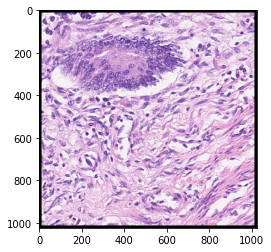

Predicted Mask Sigmoid


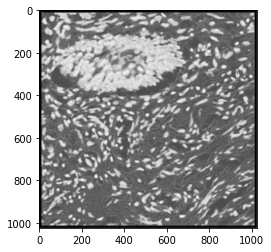

Predicted Mask Binary


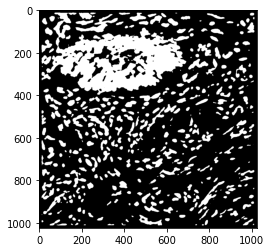

Actual Mask


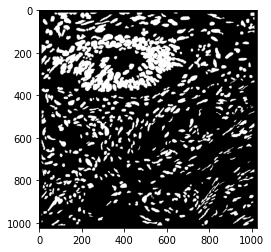

0.6564335654804901 



In [93]:
def test(model, device, test_loader):
    iou_scores = []

    for data, target in test_loader:
        print("Input Image")
        plt.imshow(data[0].numpy().transpose(1, 2, 0))
        plt.show()
        outputs = model(data.to(device))
        pred = outputs.to('cpu').detach().numpy()[0][0]

        print("Predicted Mask Sigmoid")
        plt.imshow(pred,cmap='gray')
        plt.show()
        threshold=0.95
        pred[pred >= threshold] = 1
        pred[pred < threshold] = 0
        print("Predicted Mask Binary")
        plt.imshow(pred,cmap='gray')
        plt.show()
        print("Actual Mask")
        plt.imshow(target[0],cmap='gray')
        plt.show()

        # iou
        target_ts = target[0].to('cpu').detach().numpy()
        intersection = np.logical_and(target_ts, pred)
        union = np.logical_or(target_ts, pred)
        iou_score = np.sum(intersection) / np.sum(union)
        print(iou_score, "\n")

        iou_scores.append(iou_score)

        break


# Testing the model
test(model, device, test_loader)

# Load model


In [92]:
# load saved model
def load_model(model):
  path = f"model_checkpoints/{model.__class__.__name__}.pt"
  model.load_state_dict(torch.load(path)) 
  model.eval()
  return model
model = load_model(model)

# Hyperparameter Tuning

In [ ]:
def hyperparam_tuning(bs, lr, epochs):
    print("Batch size: {}, Learning rate: {} , Epochs: {}\n".format(bs, lr, epochs))
    
    # DataLoader
    train_ds = CellDataset(root_dir="./Train", transform = transform)
    train_dataloader = DataLoader(train_ds, batch_size=bs, shuffle=False)

    test_ds = CellDataset(root_dir="./Test", transform = transform)
    test_dataloader = DataLoader(test_ds, batch_size=bs, shuffle=False)
    
    # Set cpu / gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model and optimizer
    model = build_model(device)
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    
    # Train model
    train(model, device, train_dataloader, optimizer, epochs)
    
    # Test model
    test(model, device, test_loader)

In [ ]:
n_bs = [1]
n_epochs = [20, 30, 40]
n_lr = [0.001, 0.0001, 0.00001]

for bs in n_bs:
    for lr in n_lr:
        for epochs in n_epochs:
            hyperparam_tuning(bs, lr, epochs)